In [256]:
import pandas as pd
import numpy as np
from binance.client import Client
#from talib import EMA, CDLHAMMER

import matplotlib.pyplot as plt
import mplfinance as mpf

import talib

import datetime
from datetime import datetime

%matplotlib inline


#PLACE SECRETS ON .ENV
secs = open(".env", 'r').read()
secs = dict([i.split("=") for i in secs.split("\n") if i])

PUBLIC = secs["PUBLIC"]
SECRET = secs["SECRET"]

client = Client(api_key=PUBLIC, api_secret=SECRET)



In [32]:
#class TechProcs:

def calc_technical_indicators(df, column_name: str, id: int, all: bool, verbose: bool):
    """
    Calculates a set of selecteed technical indicators based on the close price of the given stock
    :param df: pandas data frame
    :param column_name: MUST refer to the close price of the stock
    :return: Void - modifies the frame in place
    """
    close = np.asarray(df[column_name])
    # This is for experimenting to generate a wide range of technical indicators
    # requires subsequent feature ranking
    full_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29]
    short_range = [3, 5, 7, 10, 15, 20, 25]
    long_range = [50, 60, 70, 80, 100, 150, 200, 250]
    range = full_range + long_range

    if (id == 1 or all):
        # Bollinger bands
        df['UP_BB'], df['MID_BB'], df['LOW_BB'] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        if (verbose):
            print("ID: " + str(id))
            print("Bollinger bands")
            print(df.corr())

    if (id == 2 or all):
        # Create Simple Moving Average
        # Time range adjusted based on feature ranking for S&P500
        periods = range  # [2, 3, 4, 5, 7]
        for period in periods:
            df['SMA-' + str(period)] = talib.SMA(close, timeperiod=period)
        if (verbose):
            print("ID: " + str(id))
            print("Simple Moving Average")
            print(df.corr())

    if (id == 3 or all):
        # Create Exponential moving average
        # correlation drops at 30 and beyond
        # time range adjusted based on feature ranking for S&P500
        periods = range  # [6,7,9,12]
        for period in periods:
            df['EMA-' + str(period)] = talib.EMA(close, timeperiod=period)
        if (verbose):
            print("ID: " + str(id))
            print("Exponential Moving Average")
            print(df.corr())

    if (id == 4 or all):

        # Create Momentum
        # no strong correlation for the MOM indicators was found, thus disabled.
        # only MOM-300 yields about ~ -30% Corr.
        periods = range
        for period in periods:
            df['MOM-' + str(period)] = talib.MOM(close, timeperiod=period)
        if (verbose):
            print("ID: " + str(id))
            print("Momentum")
            print(df.corr())

    if (id == 5 or all):
        # Create RSI
        # Time range adjusted based on feature ranking for S&P500
        periods = range  # [10, 11, 12, 13, 14, 15, 21, 22]
        for period in periods:
            df['RSI-' + str(period)] = talib.RSI(close, timeperiod=period)
        if (verbose):
            print("ID: " + str(id))
            print("RSI")
            print(df.corr())

    if (id == 6 or all):
        # Create TRIX
        # Time range adjusted based on feature ranking for S&P500
        # For a smaller sample size, only Trix-30 shows higehst correlation to close price.
        # Add full range to re-test and look how Trix-30 performs
        periods = range  # [3, 4]  # range
        for period in periods:
            df['TRIX-' + str(period)] = talib.TRIX(close, timeperiod=period)

        if (verbose):
            print("ID: " + str(id))
            print("Trix")
            print(df.corr())

    if (id == 7 or all):
        # Cycle Indicator Functions
        # https://mrjbq7.github.io/ta-lib/func_groups/cycle_indicators.html
        df["HT_DCPERIOD"] = talib.HT_DCPERIOD(close)
        df["HT_DCPHASE"] = talib.HT_DCPHASE(close)
        df["HT_TRENDMODE"] = talib.HT_TRENDMODE(close)
        if (verbose):
            print("ID: " + str(id))
            print("Cycle Indicator Functions")
            print(df.corr())

def calc_all_features(df):
    open = np.asarray(df['Open'])
    close = np.asarray(df['Close'])
    high = np.asarray(df['High'])
    low = np.asarray(df['Low'])
    volume = df['Volume']  # . For magic reasons, volume must be a pandas data frame.

    get_price_studies(open, low, high, close, df)
    get_average_studies(open, low, high, close, df)
    get_volume_studies(open, low, high, close, volume, df)
    get_momentum_studies(open, low, high, close, volume, df)
    get_cycle_studies(close, df)

def get_price_studies(open, low, high, close, df):
    # https://mrjbq7.github.io/ta-lib/func_groups/price_transform.html
    df["AVGPRICE"] = talib.AVGPRICE(open, high, low, close)
    df["MEDPRICE"] = talib.MEDPRICE(high, low)
    df["TYPPRICE"] = talib.TYPPRICE(high, low, close)
    df["WCLPRICE"] = talib.WCLPRICE(high, low, close)
    df["ATR-5"] = talib.ATR(high, low, close, timeperiod=5)
    df["ATR-10"] = talib.ATR(high, low, close, timeperiod=10)
    df["ATR-20"] = talib.ATR(high, low, close, timeperiod=20)
    df["ATR-50"] = talib.ATR(high, low, close, timeperiod=50)
    df["ATR-200"] = talib.ATR(high, low, close, timeperiod=200)

def get_volume_studies(open, low, high, close, volume, df):
    # Volume Indicator Functions
    # @TODO: Fix type case error of volume column
    # https://mrjbq7.github.io/ta-lib/func_groups/volume_indicators.html
    df["AD"] = talib.AD(high, low, close, volume)
    df["ADOSC"] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df["OBV"] = talib.OBV(close, volume)

def get_momentum_studies(open, low, high, close, volume, df):
    # Momentum studies
    # https://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html
    df['MACD'], df['MACD_SIGN'], df['MACD_HIST'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    df['STOCH-SLOW-K'], df['STOCH-SLOW-D'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3,
                                                         slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCH-FAST-K'], df['STOCH-FAST-D'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3,
                                                          fastd_matype=0)
    df['STOCH-RSI-K'], df['STOCH-RSI-D'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3,
                                                          fastd_matype=0)
    df['AROON-DOWN'], df['AROON-UP'] = talib.AROON(high, low, timeperiod=14)
    df["MINUS_DI"] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df["MINUS_DM"] = talib.MINUS_DM(high, low, timeperiod=14)
    df["PLUS_DI"] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df["PLUS_DM"] = talib.PLUS_DM(high, low, timeperiod=14)
    df["MOM"] = talib.MOM(close, timeperiod=10)
    df["MFI"] = talib.MFI(high, low, close, volume, timeperiod=14)
    df["ADX"] = talib.ADX(high, low, close, timeperiod=14)
    df["ADXR"] = talib.ADXR(high, low, close, timeperiod=14)
    df["APO"] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df["AROONOSC"] = talib.AROONOSC(high, low, timeperiod=14)
    df["BOP"] = talib.BOP(open, high, low, close)
    df["CCI"] = talib.CCI(high, low, close, timeperiod=14)
    df["CMO"] = talib.CMO(close, timeperiod=14)
    df["DX"] = talib.DX(high, low, close, timeperiod=14)
    df["PPO"] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
    df["ROC"] = talib.ROC(close, timeperiod=10)
    df["RSI"] = talib.RSI(close, timeperiod=14)
    df["TRIX"] = talib.TRIX(close, timeperiod=30)
    df["ULT"] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df["WILLR"] = talib.WILLR(high, low, close, timeperiod=14)

def get_average_studies(open, low, high, close, df):
    # https://mrjbq7.github.io/ta-lib/func_groups/overlap_studies.html
    # Bollinger bands
    df['UP_BB'], df['MID_BB'], df['LOW_BB'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    # HT_TRENDLINE - Hilbert Transform - Instantaneous Trendline
    df["HT"] = talib.HT_TRENDLINE(close)
    # SAR - Parabolic SAR
    df["SAR"] = talib.SAR(high, low, acceleration=0, maximum=0)
    #
    periods = [5, 15, 30, 50, 100, 200]
    for period in periods:
        df['SMA-' + str(period)] = talib.SMA(close, timeperiod=period)
        df['DEMA-' + str(period)] = talib.DEMA(close, timeperiod=period)
        df['TEMA-' + str(period)] = talib.TEMA(close, timeperiod=period)
        df['WMA-' + str(period)] = talib.WMA(close, timeperiod=period)
        df['MIDPOINT-' + str(period)] = talib.MIDPOINT(close, timeperiod=period)
        df['MIDPRICE-' + str(period)] = talib.MIDPRICE(high, low, timeperiod=period)

def get_cycle_studies(close, df):
    # Cycle Indicator Functions
    # https://mrjbq7.github.io/ta-lib/func_groups/cycle_indicators.html
    df["HT_DCPERIOD"] = talib.HT_DCPERIOD(close)
    df["HT_DCPHASE"] = talib.HT_DCPHASE(close)
    df["HT_TRENDMODE"] = talib.HT_TRENDMODE(close)

def get_chart_patterns(df):
    open = df['Open']
    close = df['Close']
    high = df['High']
    low = df['Low']
    # all 61 chart patterns in TA lib version 4.0.17
    # converted all int32 to bool as to conserve memory and storage
    # https://mrjbq7.github.io/ta-lib/func_groups/pattern_recognition.html
    df["CDL2CROWS"] = talib.CDL2CROWS(open, high, low, close).astype(bool)  # CDL2CROWS - Two Crows
    df["CDL3BLACKCROWS"] = talib.CDL3BLACKCROWS(open, high, low, close).astype(
        bool)  # CDL3BLACKCROWS - Three Black Crows
    df["CDL3INSIDE"] = talib.CDL3INSIDE(open, high, low, close).astype(bool)  # CDL3INSIDE - Three Inside Up/Down
    df["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(open, high, low, close).astype(
        bool)  # CDL3LINESTRIKE - Three-Line Strike
    df["CDL3OUTSIDE"] = talib.CDL3OUTSIDE(open, high, low, close).astype(
        bool)  # CDL3OUTSIDE - Three Outside Up/Down
    df["CDL3STARSINSOUTH"] = talib.CDL3STARSINSOUTH(open, high, low, close).astype(
        bool)  # CDL3STARSINSOUTH - Three Stars In The South
    df["CDL3WHITESOLDIERS"] = talib.CDL3WHITESOLDIERS(open, high, low, close).astype(
        bool)  # CDL3WHITESOLDIERS - Three Advancing White Soldiers
    df["CDLABANDONEDBABY"] = talib.CDLABANDONEDBABY(open, high, low, close, penetration=0).astype(
        bool)  # CDLABANDONEDBABY - Abandoned Baby
    df["CDLADVANCEBLOCK"] = talib.CDLADVANCEBLOCK(open, high, low, close).astype(
        bool)  # CDLADVANCEBLOCK - Advance Block
    df["CDLBELTHOLD"] = talib.CDLBELTHOLD(open, high, low, close).astype(bool)  # CDLBELTHOLD - Belt-hold
    df["CDLBREAKAWAY"] = talib.CDLBREAKAWAY(open, high, low, close).astype(bool)  # CDLBREAKAWAY - Breakaway
    df["CDLCLOSINGMARUBOZU"] = talib.CDLCLOSINGMARUBOZU(open, high, low, close).astype(
        bool)  # CDLCLOSINGMARUBOZU - Closing Marubozu
    df["CDLCONCEALBABYSWALL"] = talib.CDLCONCEALBABYSWALL(open, high, low, close).astype(
        bool)  # CDLCONCEALBABYSWALL - Concealing Baby Swallow # WTF???
    df["CDLCOUNTERATTACK"] = talib.CDLCOUNTERATTACK(open, high, low, close).astype(
        bool)  # CDLCOUNTERATTACK - Counterattack
    df["CDLDARKCLOUDCOVER"] = talib.CDLDARKCLOUDCOVER(open, high, low, close, penetration=0).astype(
        bool)  # CDLDARKCLOUDCOVER - Dark Cloud Cover
    df["CDLDOJI"] = talib.CDLDOJI(open, high, low, close).astype(bool)  # CDLDOJI - Doji
    df["CDLDOJISTAR"] = talib.CDLDOJISTAR(open, high, low, close).astype(bool)  # CDLDOJISTAR - Doji Star
    df["CDLDRAGONFLYDOJI"] = talib.CDLDRAGONFLYDOJI(open, high, low, close).astype(bool)  # Dragonfly Doji
    df["CDLENGULFING"] = talib.CDLENGULFING(open, high, low, close).astype(bool)  # Engulfing Pattern
    df["CDLEVENINGDOJISTAR"] = talib.CDLEVENINGDOJISTAR(open, high, low, close, penetration=0).astype(
        bool)  # Evening Doji Star
    df["CDLEVENINGSTAR"] = talib.CDLEVENINGSTAR(open, high, low, close, penetration=0).astype(bool)  # Evening Star
    df["CDLGAPSIDESIDEWHITE"] = talib.CDLGAPSIDESIDEWHITE(open, high, low, close).astype(
        bool)  # Up/Down-gap side-by-side white lines
    df["CDLGRAVESTONEDOJI"] = talib.CDLGRAVESTONEDOJI(open, high, low, close).astype(bool)  # Gravestone Doji
    df["CDLHAMMER "] = talib.CDLHAMMER(open, high, low, close).astype(bool)  # Hammer
    df["CDLHANGINGMAN"] = talib.CDLHANGINGMAN(open, high, low, close).astype(bool)  # Hanging Man
    df["CDLHARAMI"] = talib.CDLHARAMI(open, high, low, close).astype(bool)  # Harami Pattern
    df["CDLHARAMICROSS"] = talib.CDLHARAMICROSS(open, high, low, close).astype(bool)  # Harami Cross Pattern
    df["CDLHIGHWAVE"] = talib.CDLHIGHWAVE(open, high, low, close).astype(bool)  # High-Wave Candle
    df["CDLHIKKAKE"] = talib.CDLHIKKAKE(open, high, low, close).astype(bool)  # Hikkake Pattern
    df["CDLHIKKAKEMOD"] = talib.CDLHIKKAKEMOD(open, high, low, close).astype(bool)  # Modified Hikkake Pattern
    df["CDLHOMINGPIGEON"] = talib.CDLHOMINGPIGEON(open, high, low, close).astype(bool)  # Homing Pigeon
    df["CDLIDENTICAL3CROWS"] = talib.CDLIDENTICAL3CROWS(open, high, low, close).astype(
        bool)  # Identical Three Crows
    df["CDLINNECK"] = talib.CDLINNECK(open, high, low, close).astype(bool)  # In-Neck Pattern
    df["CDLINVERTEDHAMMER"] = talib.CDLINVERTEDHAMMER(open, high, low, close).astype(bool)  # Inverted Hammer
    df["CDLKICKING"] = talib.CDLKICKING(open, high, low, close).astype(bool)  # Kicking
    df["CDLKICKINGBYLENGTH"] = talib.CDLKICKINGBYLENGTH(open, high, low, close).astype(
        bool)  # Kicking - bull/bear determined by the longer marubozu
    df["CDLLADDERBOTTOM"] = talib.CDLLADDERBOTTOM(open, high, low, close).astype(bool)  # Ladder Bottom
    df["CDLLONGLEGGEDDOJI"] = talib.CDLLONGLEGGEDDOJI(open, high, low, close).astype(bool)  # Long Legged Doji
    df["CDLLONGLINE"] = talib.CDLLONGLINE(open, high, low, close).astype(bool)  # Long Line Candle
    df["CDLMARUBOZU"] = talib.CDLMARUBOZU(open, high, low, close).astype(bool)  # Marubozu
    df["CDLMATCHINGLOW"] = talib.CDLMATCHINGLOW(open, high, low, close).astype(bool)  # Matching Low
    df["CDLMATHOLD"] = talib.CDLMATHOLD(open, high, low, close, penetration=0).astype(bool)  # Mat Hold
    df["CDLMORNINGDOJISTAR"] = talib.CDLMORNINGDOJISTAR(open, high, low, close, penetration=0).astype(
        bool)  # Morning Doji Star
    df["CDLMORNINGSTAR"] = talib.CDLMORNINGSTAR(open, high, low, close, penetration=0).astype(bool)  # Morning Star
    df["CDLONNECK"] = talib.CDLONNECK(open, high, low, close).astype(bool)  # On-Neck Pattern
    df["CDLPIERCING"] = talib.CDLPIERCING(open, high, low, close).astype(bool)  # Piercing Pattern
    df["CDLRICKSHAWMAN"] = talib.CDLRICKSHAWMAN(open, high, low, close).astype(bool)  # Rickshaw Man
    df["CDLRISEFALL3METHODS"] = talib.CDLRISEFALL3METHODS(open, high, low, close).astype(
        bool)  # Rising/Falling Three Methods
    df["CDLSEPARATINGLINES"] = talib.CDLSEPARATINGLINES(open, high, low, close).astype(bool)  # Separating Lines
    df["CDLSHOOTINGSTAR"] = talib.CDLSHOOTINGSTAR(open, high, low, close).astype(bool)  # Shooting Star
    df["CDLSHORTLINE"] = talib.CDLSHORTLINE(open, high, low, close).astype(bool)  # Short Line Candle
    df["CDLSPINNINGTOP"] = talib.CDLSPINNINGTOP(open, high, low, close).astype(bool)  # Spinning Top
    df["CDLSTALLEDPATTERN"] = talib.CDLSTALLEDPATTERN(open, high, low, close).astype(bool)  # Stalled Pattern
    df["CDLSTICKSANDWICH"] = talib.CDLSTICKSANDWICH(open, high, low, close).astype(bool)  # Stick Sandwich
    df["CDLTAKURI"] = talib.CDLTAKURI(open, high, low, close).astype(
        bool)  # Takuri (Dragonfly Doji with very long lower shadow)
    df["CDLTASUKIGAP"] = talib.CDLTASUKIGAP(open, high, low, close).astype(bool)  # Tasuki Gap
    df["CDLTHRUSTING"] = talib.CDLTHRUSTING(open, high, low, close).astype(bool)  # Thrusting Pattern
    df["CDLTRISTAR"] = talib.CDLTRISTAR(open, high, low, close).astype(bool)  # Tristar Pattern
    df["CDLUNIQUE3RIVER"] = talib.CDLUNIQUE3RIVER(open, high, low, close).astype(bool)  # Unique 3 River
    df["CDLUPSIDEGAP2CROWS"] = talib.CDLUPSIDEGAP2CROWS(open, high, low, close).astype(bool)  # Upside Gap Two Crows
    df["CDLXSIDEGAP3METHODS "] = talib.CDLXSIDEGAP3METHODS(open, high, low, close).astype(
        bool)  # Upside/Downside Gap Three Methods



In [395]:
klines = client.get_historical_klines("BNBUSDT", Client.KLINE_INTERVAL_1MINUTE, "10 Aug 2020" ,"12 Aug 2020")

df = pd.DataFrame(klines, columns=["Open time", "Open", "High","Low", "Close", "Volume", "Close time", "Quote asset volume", "Number of trades", "tkb", "tkbq","ignore"])

dd = df[['Open time', 'Open', 'Close',"High","Low","Volume"]]

dd['Open time'] = df['Open time'].apply( lambda x: datetime.fromtimestamp(x/1000) ) #timestamps to date %Y%M%D
dd = dd.set_index('Open time') #used by mpf


dd = dd.astype({    
    "Close": "float",
    "Open" : "float",
    "High" : "float",
    "Low"  : "float",
    "Volume": "float",
})


calc_all_features(dd)

print(dd.columns)



Index(['Open', 'Close', 'High', 'Low', 'Volume', 'AVGPRICE', 'MEDPRICE',
       'TYPPRICE', 'WCLPRICE', 'ATR-5', 'ATR-10', 'ATR-20', 'ATR-50',
       'ATR-200', 'UP_BB', 'MID_BB', 'LOW_BB', 'HT', 'SAR', 'SMA-5', 'DEMA-5',
       'TEMA-5', 'WMA-5', 'MIDPOINT-5', 'MIDPRICE-5', 'SMA-15', 'DEMA-15',
       'TEMA-15', 'WMA-15', 'MIDPOINT-15', 'MIDPRICE-15', 'SMA-30', 'DEMA-30',
       'TEMA-30', 'WMA-30', 'MIDPOINT-30', 'MIDPRICE-30', 'SMA-50', 'DEMA-50',
       'TEMA-50', 'WMA-50', 'MIDPOINT-50', 'MIDPRICE-50', 'SMA-100',
       'DEMA-100', 'TEMA-100', 'WMA-100', 'MIDPOINT-100', 'MIDPRICE-100',
       'SMA-200', 'DEMA-200', 'TEMA-200', 'WMA-200', 'MIDPOINT-200',
       'MIDPRICE-200', 'AD', 'ADOSC', 'OBV', 'MACD', 'MACD_SIGN', 'MACD_HIST',
       'STOCH-SLOW-K', 'STOCH-SLOW-D', 'STOCH-FAST-K', 'STOCH-FAST-D',
       'STOCH-RSI-K', 'STOCH-RSI-D', 'AROON-DOWN', 'AROON-UP', 'MINUS_DI',
       'MINUS_DM', 'PLUS_DI', 'PLUS_DM', 'MOM', 'MFI', 'ADX', 'ADXR', 'APO',
       'AROONOSC', 'BOP', 'CCI'

<ipython-input-395-8679f25302bb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['Open time'] = df['Open time'].apply( lambda x: datetime.fromtimestamp(x/1000) ) #timestamps to date %Y%M%D


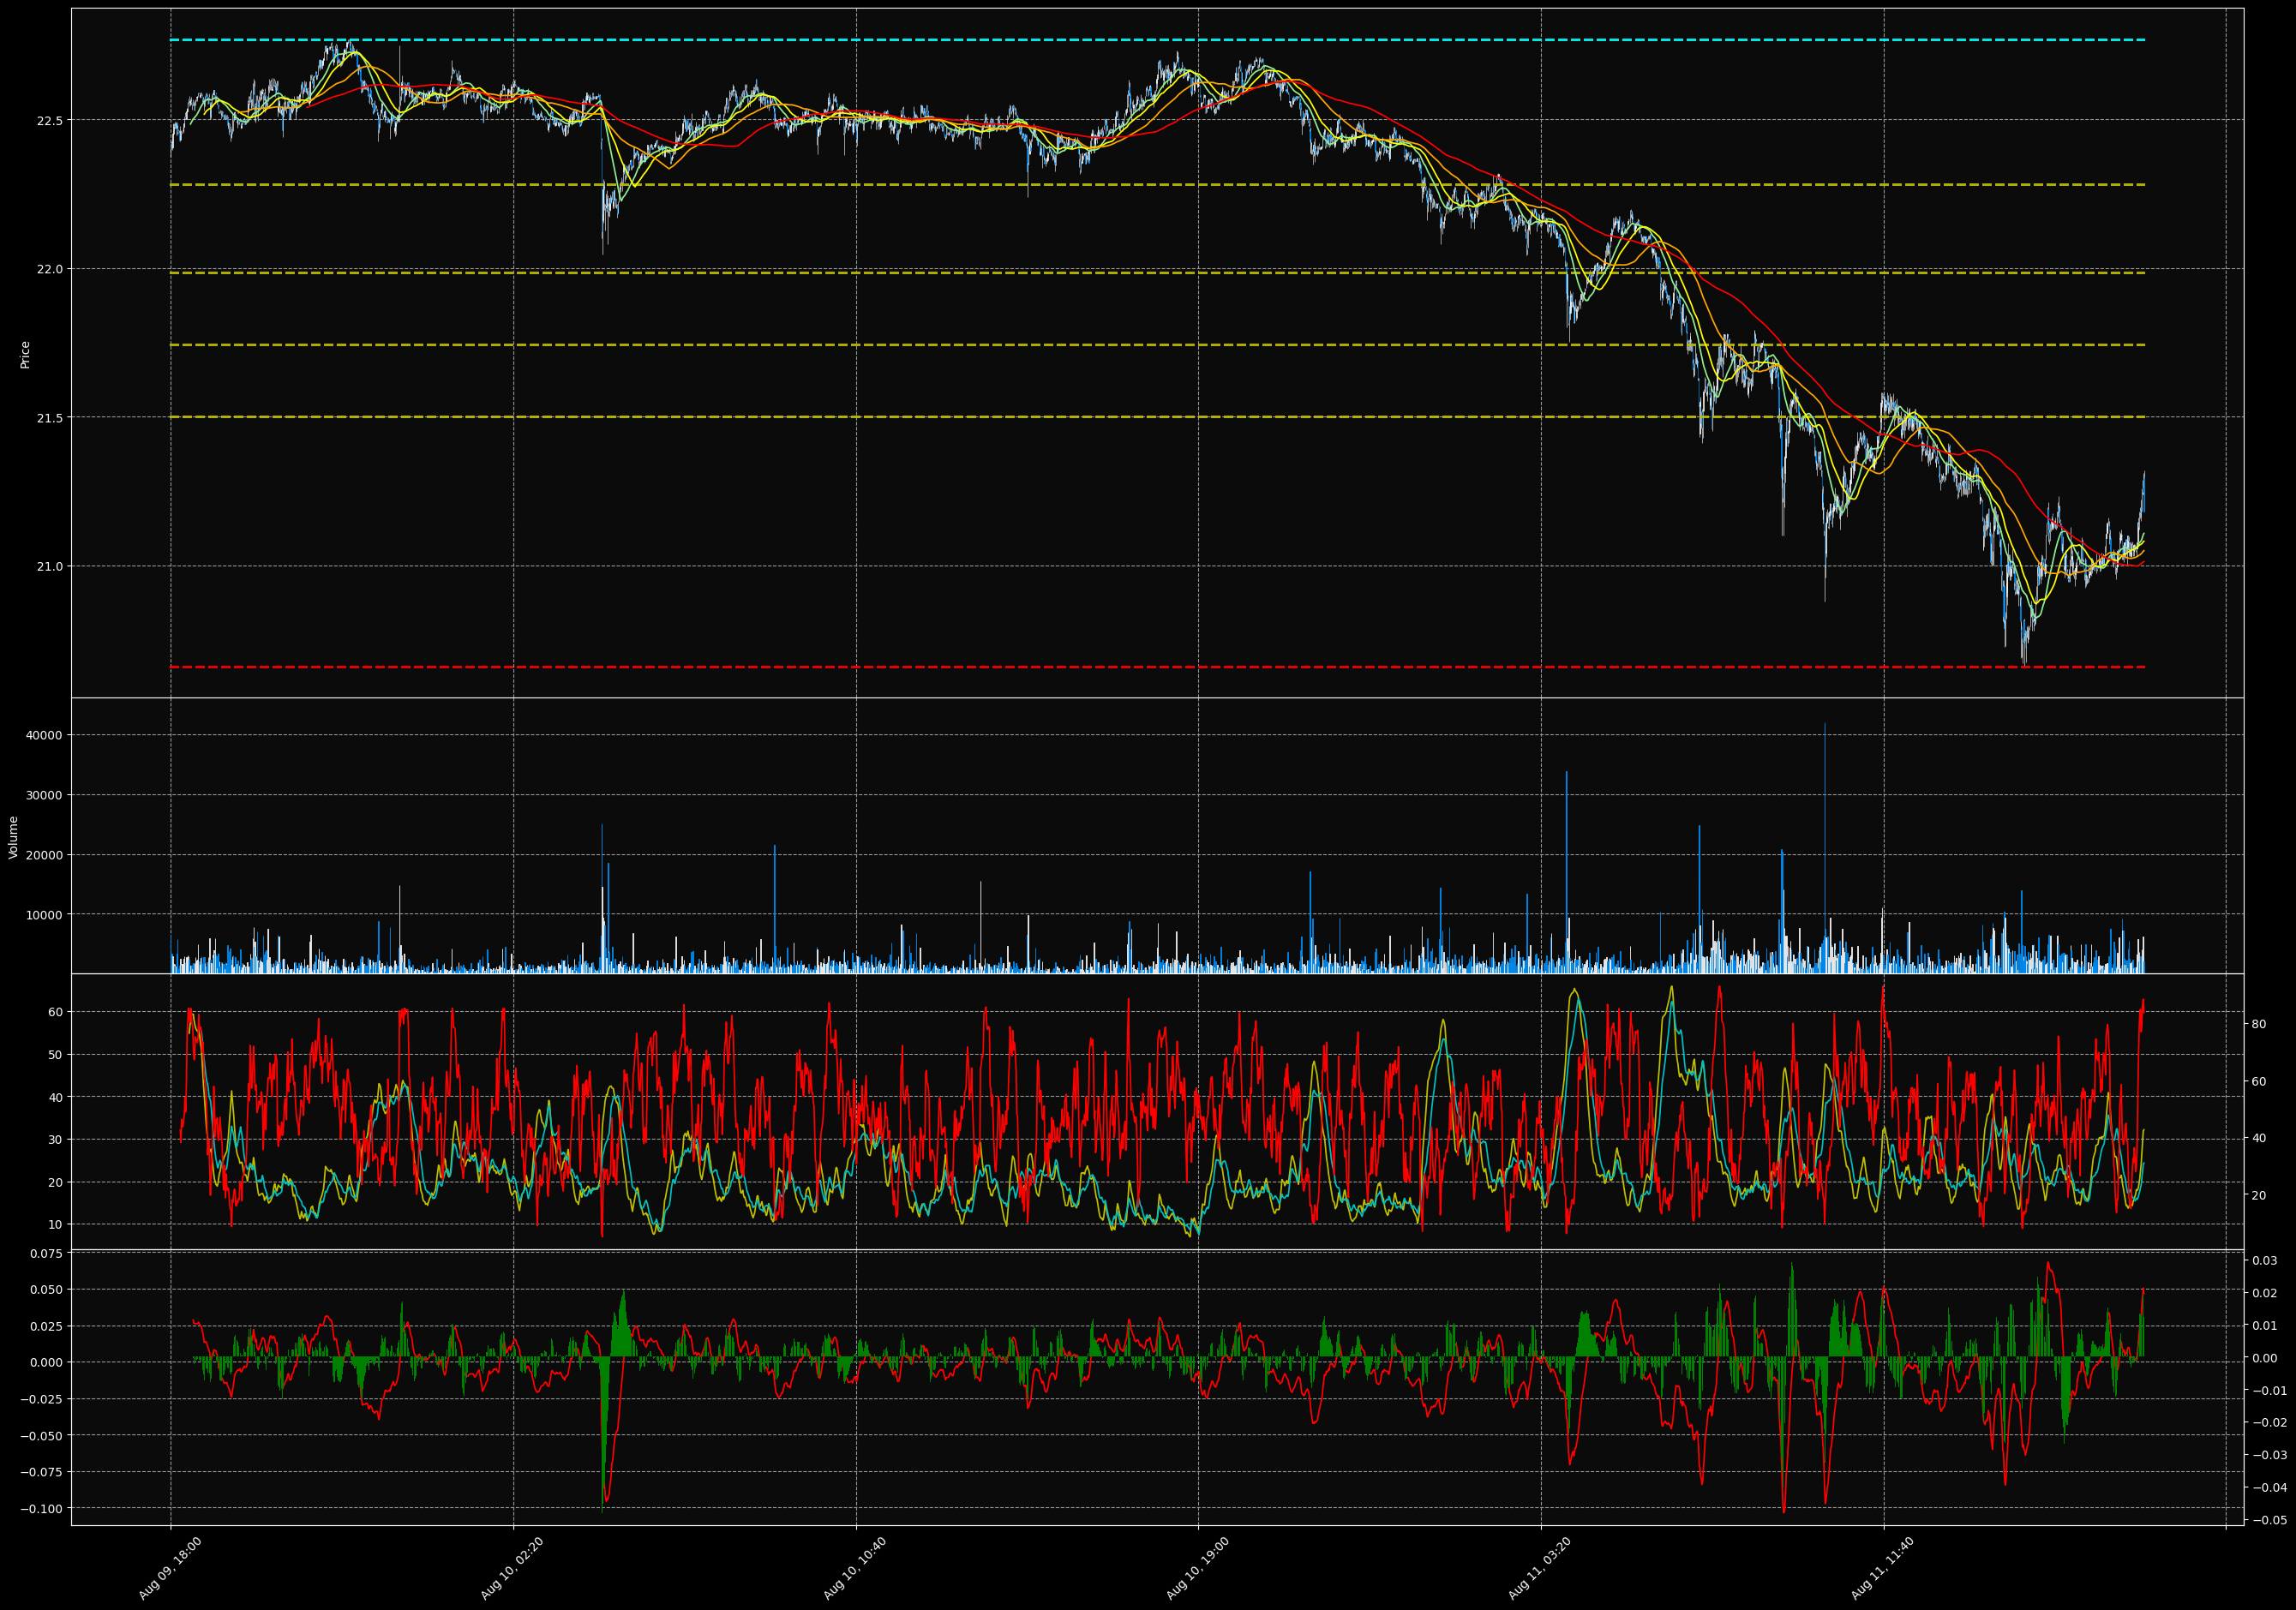

In [396]:
EMAS = [
    mpf.make_addplot(dd["SMA-30"],color="lightgreen"),
    mpf.make_addplot(dd["SMA-50"],color="yellow"),
    mpf.make_addplot(dd["SMA-100"],color="orange"),
    mpf.make_addplot(dd["SMA-200"],color="red"),
    #mpf.make_addplot(dd["UP_BB"],color="green"),
    #mpf.make_addplot(dd["MID_BB"],color="white"),
    #mpf.make_addplot(dd["LOW_BB"],color="red"),
    #mpf.make_addplot((dd["WILLR"]),panel=1, color="cyan", type='bar'),

    #mpf.make_addplot((dd["AROONOSC"]),panel=1, color="y"),
    mpf.make_addplot((dd["MACD"]),panel=3, color="red"),
    mpf.make_addplot((dd["MACD_HIST"]),panel=3,type='bar', color="green"),
    mpf.make_addplot((dd["ADX"]),panel=2, color="y"),
    mpf.make_addplot((dd["ADXR"]),panel=2, color="c"),
    mpf.make_addplot((dd["MFI"]),panel=2, color="r"),
    #mpf.make_addplot((dd["RSI"]),panel=3, color="w"),

]

#a = dd["Open"][ dd["Open"] == sorted(dd["Open"].values)[15] ]
#b = dd["Open"][ dd["Open"] == sorted(dd["Open"].values)[-1] ]
#line1 = (str(a.keys()[0]), a.values[0])
#line2 = (str(b.keys()[0]), b.values[0])


#lines
lines = [ (str(a),b) for a,b in dd["Low"].items() ]

#supports and resistance
histS, borderS  = np.histogram( dd["Low"].values, density=False )
histR, borderR  = np.histogram( dd["High"].values, density=False )
support = min(borderS)
resistance = max(borderR)

#fibonacci retracement
price_min = dd["Close"].min()
price_max = dd["Close"].max()
diff = price_max - price_min
level1 = price_max - 0.236 * diff
level2 = price_max - 0.382 * diff
level3 = price_max - 0.500 * diff
level4 = price_max - 0.618 * diff

fibonacci = level1, level2, level3, level4

#sr = borderS[np.argmax(hist)]

kargs = dict(type='candle', figscale=4.4, addplot=EMAS )

mpf.plot(dd,**kargs, style='nightclouds', \
                 # alines=dict(alines=lines, colors="gray"), \
                 hlines=dict(hlines=[support,resistance,*fibonacci], \
                             colors=['r','cyan','y','y','y','y'], \
                             linestyle='--', \
                             linewidths=2,alpha=0.9, \
                            ), \
                 volume=True)




<ipython-input-387-259499c88e91>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HA['Open'][i]= ( (df['Open'][i] + df['Close'][i] )/ 2)
<ipython-input-387-259499c88e91>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HA['Open'][i] = ( (df['Open'][i-1] + df['Close'][i-1] )/ 2)


Axes(0.18,0.561818;0.72x0.318182)


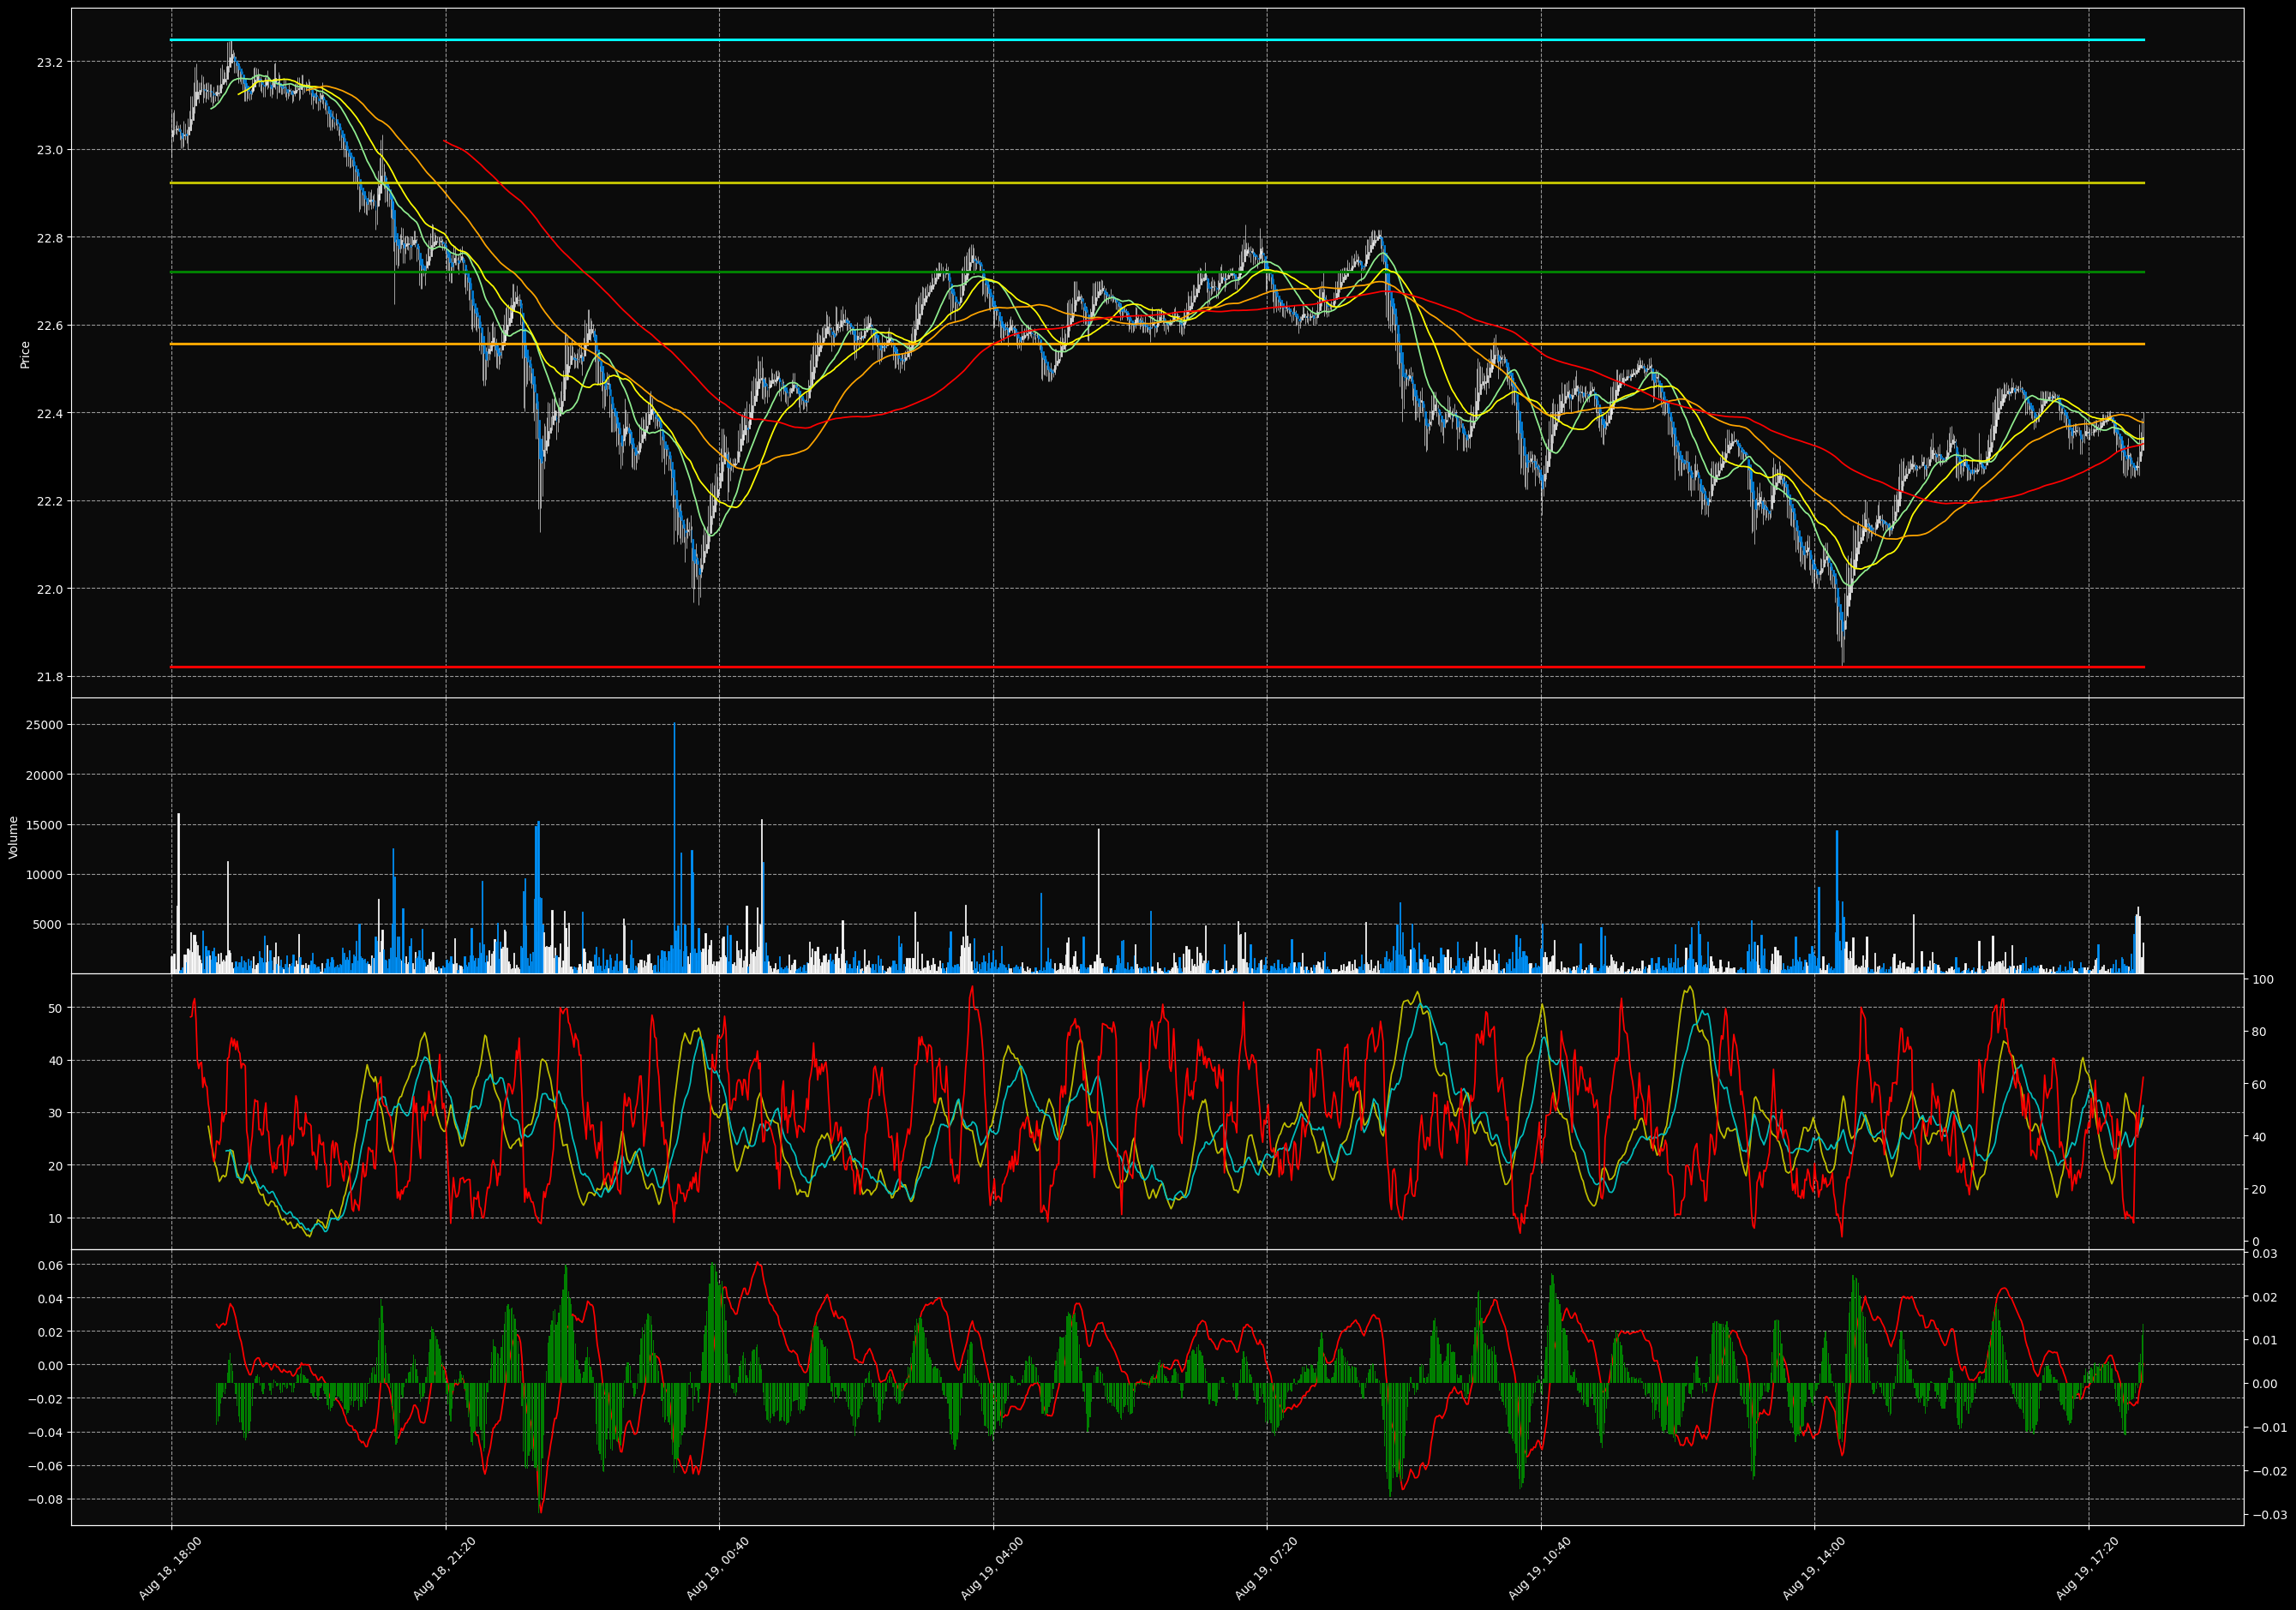

In [387]:
def HA(df):
    df_HA = df
    df_HA['Close']=(df['Open']+ df['High']+ df['Low']+df['Close'])/4

    #idx = df_HA.index.name
    #df_HA.reset_index(inplace=True)

    for i in range(0, len(df)):
        if i == 0:
            df_HA['Open'][i]= ( (df['Open'][i] + df['Close'][i] )/ 2)
        else:
            df_HA['Open'][i] = ( (df['Open'][i-1] + df['Close'][i-1] )/ 2)


    #if idx:
        #df_HA.set_index(idx, inplace=True)

    df_HA['High']=df[['Open','Close','High']].max(axis=1)
    df_HA['Low']=df[['Open','Close','Low']].min(axis=1)
    return df_HA

dd2 = dd
HA(dd2)

a,b = mpf.plot(dd2,**kargs, style='nightclouds', \
                 # alines=dict(alines=lines, colors="gray"), \
                 hlines=dict(hlines=[support,resistance,level1,level2,level3], \
                             colors=['r','cyan','y','g','orange'], \
                             linestyle='-'), \
                 volume=True, returnfig=True)


print(b[0])